# Phone Price Prediction Project

In [1]:
import re
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from itables import show
import seaborn as sns

In [2]:
df = pd.read_csv('phone_data.csv', index_col='Unnamed: 0')

In [3]:
show(df, maxBytes=0)

The column names are in Indonesian and they contain spaces. Let's translate them to english and standardize the column format using `column_mapper.csv` before we proceed to data analysis

In [4]:
column_mapper = pd.read_csv('column_mapper.csv', index_col='col_id').squeeze().to_dict()
df.columns = df.columns.map(column_mapper)
df.columns

Index(['price', 'category', 'brand', 'release_year', 'product_name',
       '2g_network', '3g_network', '4g_network', 'network', 'dimension',
       'weight', 'num_sim_slots', 'sim_card_type', 'color',
       'screen_resolution', 'screen_size', 'technology', 'os_version',
       'os_version_detail', 'os', 'processor', 'processor_detail', 'cpu_speed',
       'gpu', 'num_core', 'ram', 'internal_memory', 'external_memory_type',
       'back_camera_resolution', 'other_main_camera_resolution',
       'has_dual_back_camera', 'num_back_camera', 'front_camera_resolution',
       'has_dual_front_camera', 'has_flash', 'has_dual_flash', 'video',
       'has_nfc', 'has_infrared', 'usb', 'wifi', 'bluetooth', 'gps',
       'battery_type', 'battery_material', 'battery_capacity', 'is_waterproof',
       'cencor', 'has_3.5mm_jack', '5g_network', 'material',
       'external_memory_capacity', 'has_fast_charging', 'fast_charging_power',
       'series', 'front_camera_resolution_2'],
      dtype='object')

# 1. Column Transformation

In [5]:
show(df, maxBytes=0)

We can see that the scraped datas are not very workable since they are all stored as string. We'll first transform this values into numerical for easier analysis

In [6]:
clean_df = df.copy()

In [7]:
## Extract price
clean_df['price'] = clean_df['price'].str.split("Rp").str[1].str.replace(".", "").astype(float)

In [8]:
## Map Yes or No values to 0 and 1
boolean_cols = [col for col in clean_df.columns if 'has' in col or 'is' in col]
for col in boolean_cols:
    clean_df[col] = clean_df[col].map({'Yes':1, 'No':0})

In [55]:
## Drop category
clean_df = clean_df.drop(columns=['category'])

In [56]:
## Extract memory related values
def extract_memory(string):
    if pd.isnull(string):
        return None
    
    if 'GB' in string:
        return float(string.split('GB')[0])
    
    if 'TB' in string:
        return float(string.split('TB')[0]) * 1024

memory_cols = ['ram', 'internal_memory']
for col in memory_cols:
    clean_df[col] = clean_df[col].apply(extract_memory)

TypeError: argument of type 'float' is not iterable

In [57]:
## Extract camera related values
camera_resolution_cols = ['back_camera_resolution', 'front_camera_resolution', 'front_camera_resolution_2']
for col in camera_resolution_cols:
    clean_df[col] = clean_df[col].str.split('MP').str[0].astype(float)

AttributeError: Can only use .str accessor with string values!

In [ ]:
## Extract values with constant unit
clean_df['weight'] = clean_df['weight'].str.split('g').str[0].astype(float)
clean_df['num_sim_slots'] = clean_df['num_sim_slots'].str.split('slot').str[0].astype(float)
clean_df['screen_size'] = clean_df['screen_size'].str.split('inch').str[0].astype(float)
clean_df['cpu_speed'] = clean_df['cpu_speed'].str.split('GHz').str[0].astype(float)
clean_df['battery_capacity'] = clean_df['battery_capacity'].str.split('mAh').str[0].astype(float)

In [ ]:
## Extract external memory capacity
def extract_memory_capacity(string):
    if pd.isnull(string):
        return None
    
    match = re.search(r'(\d+)\s*(GB|TB)', string, re.IGNORECASE)
    if match:
        value = int(match.group(1))
        return value * 1024 if match.group(2).upper() == 'TB' else value
    return None

clean_df['external_memory_capacity'] = clean_df['external_memory_capacity'].apply(extract_memory_capacity)

### Transforming network column

We'll drop `2g,3g,4g,5g_network` columns since the details are pretty hard to put into the models and instead, we'll just create boolean columns indicating whether a phone has 2g,3g,4g,5g network

In [58]:
## Transforming network column
for i in range(2,6):
    clean_df[f'has_{i}G_network'] = np.logical_or(f'{i}G' in clean_df['network'], ~clean_df[f'{i}g_network'].isnull())
    clean_df[f'has_{i}G_network'] = clean_df[f'has_{i}G_network'].astype(int)
clean_df = clean_df.drop(columns=['2g_network', '3g_network', '4g_network', '5g_network', 'network'])

KeyError: 'network'

### Transforming material column

In [ ]:
def extract_materials(description):
    if pd.isnull(description):
        return ('unspecified', 'unspecified', 'unspecified')
    # Define patterns for each component
    front_pattern = r'(glass|plastic|metal)(?=\s+front)'
    back_pattern = r'(glass|plastic|metal)(?=\s+back)'
    frame_pattern = r'(titanium|aluminum|steel|plastic)(?=\s+frame)'

    # Search for patterns in the description
    front_match = re.search(front_pattern, description, re.IGNORECASE)
    back_match = re.search(back_pattern, description, re.IGNORECASE)
    frame_match = re.search(frame_pattern, description, re.IGNORECASE)

    # Extract the matched materials
    front_material = front_match.group(0) if front_match else 'unspecified'
    back_material = back_match.group(0) if back_match else 'unspecified'
    frame_material = frame_match.group(0) if frame_match else 'unspecified'

    return front_material.lower(), back_material.lower(), frame_material.lower()

In [ ]:
material_df = pd.DataFrame(
    clean_df['material'].apply(extract_materials).to_list(),
    columns=['front_material', 'back_material', 'frame_material'],
    index=clean_df.index
    )
clean_df = pd.concat([clean_df, material_df], axis=1)
clean_df = clean_df.drop(columns=['material'])

### Transforming other main camera

In [59]:
# Define functions to compute mean, max, and min, handling conversion from strings
def safe_mean(lst):
    if isinstance(lst, list):
        num_lst = [float(i) for i in lst if i.isnumeric()]
        if num_lst:
            return np.mean(num_lst)
    return 0

def safe_max(lst):
    if isinstance(lst, list):
        num_lst = [float(i) for i in lst if i.isnumeric()]
        if num_lst:
            return np.max(num_lst)
    return 0

def safe_min(lst):
    if isinstance(lst, list):
        num_lst = [float(i) for i in lst if i.isnumeric()]
        if num_lst:
            return np.min(num_lst)
    return 0

In [60]:
other_main_camera = clean_df['other_main_camera_resolution'].str.split('MP').str[0].str.strip().str.split(',')

clean_df['other_main_camera_mean'] = other_main_camera.apply(safe_mean)
clean_df['other_main_camera_max'] = other_main_camera.apply(safe_max)
clean_df['other_main_camera_min'] = other_main_camera.apply(safe_min)

KeyError: 'other_main_camera_resolution'

In [61]:
clean_df = clean_df.drop(columns=['other_main_camera_resolution'])

KeyError: "['other_main_camera_resolution'] not found in axis"

In [62]:
show(clean_df, maxBytes=0)

## 2. Handling Missing Values

In [63]:
def compute_missing_values_pct(df):
    missing_values = pd.DataFrame(columns=['count', 'percentage'])
    missing_values['count'] = df.isnull().astype(int).sum()
    missing_values['percentage'] = missing_values['count'] / df.shape[0]
    missing_values = missing_values.sort_values(by='percentage', ascending=False)

    return missing_values

def show_non_missing(df, col):
    show(df.loc[~df[col].isnull(), [col, 'product_name', 'price']])

In [64]:
missing_values_pct = compute_missing_values_pct(clean_df)
show(missing_values_pct)

### 1a. Remove missing `price`

In [65]:
clean_df = clean_df.dropna(subset=['price'])
show(compute_missing_values_pct(clean_df))

### 1b. Remove columns with > 65% missing values

In [66]:
missing_values_pct = compute_missing_values_pct(clean_df)
missing_values_pct = missing_values_pct[missing_values_pct['percentage'] >= 0.65]
clean_df = clean_df.drop(columns=missing_values_pct.index)

In [67]:
show(compute_missing_values_pct(clean_df))

### 1c. Fill categorical cols with mode

In [68]:
boolean_cols = [col for col in clean_df.columns if 'has' in col or 'is' in col]
boolean_fill_value_dict = {
    col:clean_df[col].mode()[0] for col in boolean_cols if col in clean_df.columns
}
clean_df = clean_df.fillna(boolean_fill_value_dict)

In [69]:
show(compute_missing_values_pct(clean_df))

### 1d. Fill numerical cols with mean

In [70]:
fill_with_mean_cols = [
    'weight', 'cpu_speed', 'ram', 'back_camera_resolution',
    'front_camera_resolution', 'release_year', 'battery_capacity',
    'screen_size'
]
clean_df = clean_df.fillna(clean_df[fill_with_mean_cols].mean().to_dict())

In [71]:
show(compute_missing_values_pct(clean_df))

### 1e. Drop categorical cols with too many possible values

In [72]:
missing_values_pct = compute_missing_values_pct(clean_df).loc[clean_df.dtypes=='object']
missing_values_pct = missing_values_pct[missing_values_pct['percentage'] > 0]

In [73]:
too_many_unique = clean_df.loc[:, missing_values_pct.index].nunique()
too_many_unique = too_many_unique[too_many_unique > 10].index
too_many_unique

Index([], dtype='object')

In [74]:
clean_df = clean_df.drop(columns=too_many_unique)

In [75]:
show(compute_missing_values_pct(clean_df))

### Handling external memory type

In [76]:
clean_df = clean_df.fillna({'external_memory_type':clean_df['external_memory_type'].mode()[0]})

### Handling float cols with mean

In [77]:
show(compute_missing_values_pct(clean_df))

In [78]:
clean_df['battery_type'].value_counts()

battery_type
Non-Removable    1275
Removable          54
Name: count, dtype: int64

In [79]:
clean_df.loc[clean_df['battery_type']=='Non-removable', 'battery_type'] = 'Non-Removable'

In [80]:
clean_df['num_core'].value_counts()

num_core
8.0     1140
6.0       86
4.0       77
2.0       17
10.0       9
Name: count, dtype: int64

In [81]:
clean_df['num_core'] = clean_df['num_core'].map({
    'Octa Core':8,
    'Hexa Core':6,
    'Quad Core':4,
    'Dual Core':2,
    'Deca Core':10
})

In [82]:
clean_df['num_sim_slots'].value_counts()

num_sim_slots
2.0    1242
1.0      87
Name: count, dtype: int64

In [83]:
clean_df['battery_material'].value_counts()

battery_material
Lithium Polymer    971
Lithium Ion        358
Name: count, dtype: int64

In [84]:
clean_df['num_back_camera'].value_counts()

num_back_camera
3.0    497
2.0    337
4.0    262
1.0    231
5.0      2
Name: count, dtype: int64

In [85]:
clean_df['processor'].value_counts()

processor
Qualcomm      538
MediaTek      488
Exynos        149
Apple         104
Unisoc         35
Spreadtrum     12
Intel           1
Google          1
ARM             1
Name: count, dtype: int64

In [86]:
clean_df['sim_card_type'].value_counts()

sim_card_type
Nano SIM               1159
Nano SIM, eSIM           73
Micro SIM                48
Micro SIM, Nano SIM      20
Mini SIM                 12
eSIM, Nano SIM           11
Nano SIM, Micro SIM       5
Micro SIM, eSIM           1
Name: count, dtype: int64

In [87]:
cols_to_fill = ['battery_type', 'num_core', 'num_sim_slots', 'battery_material', 'num_back_camera', 'processor', 'sim_card_type']
for col in cols_to_fill:
    clean_df.loc[clean_df[col].isnull(), col] = clean_df[col].mode().values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [88]:
compute_missing_values_pct(clean_df)

count  percentage
num_core                  1329         1.0
price                        0         0.0
has_2G_network               0         0.0
has_nfc                      0         0.0
has_infrared                 0         0.0
battery_type                 0         0.0
battery_material             0         0.0
battery_capacity             0         0.0
is_waterproof                0         0.0
has_3.5mm_jack               0         0.0
has_3G_network               0         0.0
has_flash                    0         0.0
has_4G_network               0         0.0
has_5G_network               0         0.0
front_material               0         0.0
back_material                0         0.0
frame_material               0         0.0
other_main_camera_mean       0         0.0
other_main_camera_max        0         0.0
other_main_camera_min        0         0.0
has_dual_flash               0         0.0
has_dual_front_camera        0         0.0
brand                        0         0.0
os                           0         0.0
release_year                 0         0.0
product_name                 0         0.0
weight                       0         0.0
num_sim_slots                0         0.0
sim_card_type                0         0.0
screen_size                  0         0.0
os_version                   0         0.0
processor                    0         0.0
front_camera_resolution      0         0.0
cpu_speed                    0         0.0
ram                          0         0.0
internal_memory              0         0.0
external_memory_type         0         0.0
back_camera_resolution       0         0.0
has_dual_back_camera         0         0.0
num_back_camera              0         0.0
log_price                    0         0.0

### Screener for personal phone purchase

In [89]:
screener = clean_df[
    (clean_df['release_year']>=2023) & (clean_df['ram'] >= 8) & (clean_df['internal_memory'] >= 256)
    & (clean_df['has_nfc']==1) & (clean_df['has_5G_network']==1)
    ].sort_values(by='price')
show(screener, maxBytes=0)

## 2. Analyzing `price`

In [90]:
clean_df['price'].describe()

count    1.329000e+03
mean     4.475822e+06
std      4.936433e+06
min      1.680000e+05
25%      1.600000e+06
50%      2.549999e+06
75%      4.999000e+06
max      3.349900e+07
Name: price, dtype: float64

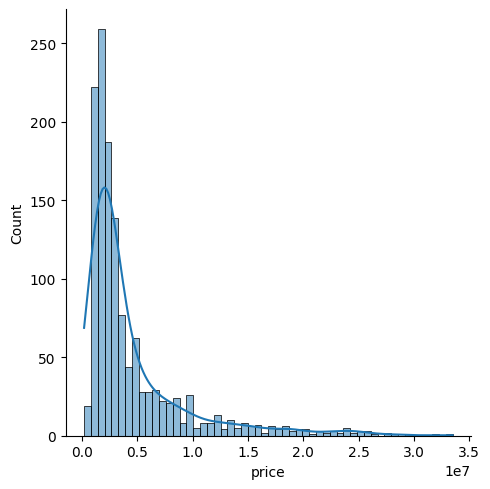

In [91]:
sns.displot(clean_df['price'], kde=True)

As always, `price` is positively skewed. Proper way to address this is to use log price later in our model as it is much less skewed, shown in the below plot

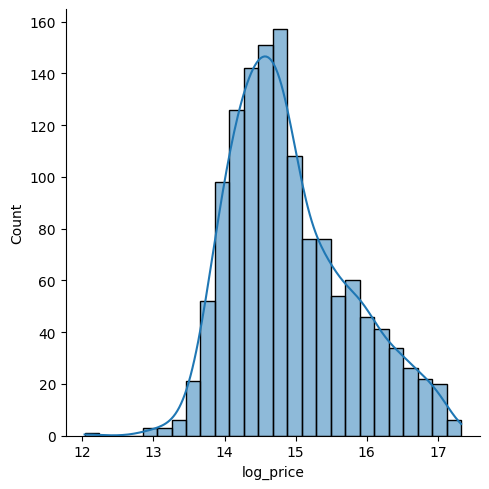

In [92]:
clean_df['log_price'] = np.log(clean_df['price'])
sns.displot(clean_df['log_price'], kde=True)

In [102]:
clean_df.corr(numeric_only=True)['log_price'].sort_values(ascending=False)

log_price                  1.000000
price                      0.892094
internal_memory            0.658529
cpu_speed                  0.636163
ram                        0.604690
has_5G_network             0.584571
has_nfc                    0.536349
other_main_camera_mean     0.518771
other_main_camera_max      0.517529
other_main_camera_min      0.515360
is_waterproof              0.394734
front_camera_resolution    0.378316
weight                     0.337927
num_back_camera            0.293978
back_camera_resolution     0.269896
has_dual_back_camera       0.240429
has_dual_flash             0.193900
has_dual_front_camera      0.130040
release_year               0.123612
has_2G_network             0.043468
has_infrared               0.038101
has_4G_network             0.028947
has_3G_network             0.028196
screen_size               -0.004624
has_flash                 -0.019804
battery_capacity          -0.117827
num_sim_slots             -0.249595
has_3.5mm_jack            -0